# Uncapacitated Lot-Sizing Problem
The problem is to decide a production plan for a $n$-period horizon for a single product.

The basic model can be viewed as having data:
- $d_t$ the demand in period $t$
- $f_t$ the fixed production cost in period $t$
- $p_t$ the unit production cost in period $t$
- $h_t$ the unit storage cost in period $t$

The production plan must satisfy the demand with a minimum cost.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
def read_data(file_name: str, keys: list) -> pd.DataFrame:
    """Read data from a .dat file and return a Pandas dataframe"""
    df = pd.read_table(file_name, sep=" ", header = None).T
    df.columns = keys
    df.index = range(1, df.shape[0] + 1)
    return df

In [188]:
FILE_PATH = "data/"
FILE_NAME = "instance_0005.dat"
KEYS = ["d", "f", "p", "h"]

df = read_data(FILE_PATH + FILE_NAME, KEYS)
n = df.shape[0]

In [189]:
df

,d,f,p,h
1,7,10,3,1
2,2,11,2,2
3,3,13,7,2
4,4,15,2,1
5,2,9,3,2


In [25]:
def plot_columns(df: pd.DataFrame) -> None:
    """Plot each column in a Pandas Dataframe"""
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(df.columns)))
    
    for i, column in enumerate(df.columns):
        ax.plot(df.index, df[column], label=column, color=colors[i], linewidth=1, marker='o', markersize=8)

    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
        
    ax.legend()
    plt.show()

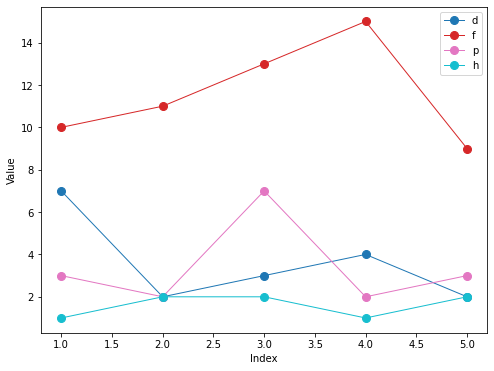

In [26]:
plot_columns(df)

In [27]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverResults
import os

def create_instance(model: pyo.AbstractModel, data: dict) -> pyo.ConcreteModel:
    """Creates a Pyomo instance for a given Pyomo abstract model and a data dictionary"""
    return model.create_instance(data = {None:data})

def solve_instance_locally(instance: pyo.ConcreteModel, solver_name: str = "cplex") -> SolverResults:
    """Solves a Pyomo instance locally"""
    solver = pyo.SolverFactory(solver_name)
    result = solver.solve(instance)
    return result

def solve_instance_externally(instance: pyo.ConcreteModel, email: str, solver_name: str = "cplex", load: bool = True) -> SolverResults:
    """Solves a Pyomo instance on the NEOS servers"""
    os.environ["NEOS_EMAIL"] = email
    solver_manager = pyo.SolverManagerFactory('neos')
    result = solver_manager.solve(instance, opt=solver_name, load_solutions=load)
    return result

## Integer Linear Programming Formulation 1

The variables :
- $x_t$ the number of items produced in period $t$, $\forall t \in \{1,\dots,n\}$
- $y_t = 1$ if production occurs in period $t$, otherwise $y_t = 0$, $\forall t \in \{1,\dots,n\}$
- $s_t$ the number of items stored at the end of period $t$, $\forall t \in \{0,\dots,n\}$

The model :

$\begin{cases}
    \text{Minimize} \sum_{t=1}^{n} f_t y_t + \sum_{t=1}^{n} p_t x_t + \sum_{t=1}^{n} h_t s_t \\
    s_{t-1} + x_t = d_t + s_t & \forall t \in \{1,\dots,n\}\\
    x_t \le M_t y_t & \forall t \in \{1,\dots,n\}\\
    y_t \in \{0, 1\} & \forall t \in \{1,\dots,n\}\\
    x_t, s_t \ge 0 & \forall t \in \{1,\dots,n\}\\
    s_0 = 0
\end{cases}$

With :
- $M_t = \sum_{k=t}^n d_k$ an upperbound of $M_t$

In [407]:
def prepare_data_uls_1(df):    
    data = df.to_dict()
    data['n'] = {None:n}
    data['M'] = {t:sum(list(data['d'].values())[t-1:]) for (t, value) in data['d'].items()}
    data['s0'] = {None:0}
    return data

In [411]:
data_uls_1 = prepare_data_uls_1(df)

In [412]:
data_uls_1

{'d': {1: 7, 2: 2, 3: 3, 4: 4, 5: 2},
 'f': {1: 10, 2: 11, 3: 13, 4: 15, 5: 9},
 'p': {1: 3, 2: 2, 3: 7, 4: 2, 5: 3},
 'h': {1: 1, 2: 2, 3: 2, 4: 1, 5: 2},
 'n': {None: 5},
 'M': {1: 18, 2: 11, 3: 9, 4: 6, 5: 2},
 's0': {None: 0}}

In [413]:
def create_uls_1() -> pyo.AbstractModel:
    model = pyo.AbstractModel()

    # immutable parameters
    model.n = pyo.Param(domain = pyo.NonNegativeIntegers)

    # sets
    model.T = pyo.Set(dimen = 1, initialize = T_set_expression)
    model.S = pyo.Set(dimen = 1, initialize = S_set_expression)

    # mutable parameters
    model.s0 = pyo.Param(domain = pyo.NonNegativeIntegers, mutable = True)

    model.d = pyo.Param(model.T, domain = pyo.NonNegativeIntegers, mutable = True)
    model.f = pyo.Param(model.T, domain = pyo.NonNegativeIntegers, mutable = True)
    model.p = pyo.Param(model.T, domain = pyo.NonNegativeIntegers, mutable = True)
    model.h = pyo.Param(model.T, domain = pyo.NonNegativeIntegers, mutable = True)

    model.M = pyo.Param(model.T, mutable = True)
    
    # variables
    model.x = pyo.Var(model.T, domain = pyo.NonNegativeIntegers)
    model.s = pyo.Var(model.S, domain = pyo.NonNegativeIntegers)
    model.y = pyo.Var(model.T, domain = pyo.Binary)
    
    # objective function
    model.objective = pyo.Objective(expr = objective_expression, sense = pyo.minimize)

    # constraints
    model.conservation_constraint  = pyo.Constraint(model.T, expr = conservation_constraint_expression)
    model.big_m_constraint         = pyo.Constraint(model.T, expr = big_m_constraint_expression)
    model.initial_stock_constraint = pyo.Constraint(expr = initial_stock_constraint_expression)
    
    return model

def T_set_expression(model: pyo.AbstractModel) -> pyo.Expression:
    return (t for t in range(1, model.n + 1))

def S_set_expression(model: pyo.AbstractModel) -> pyo.Expression:
    return (t for t in range(0, model.n + 1))

def objective_expression(model: pyo.AbstractModel) -> pyo.Expression:
    return sum(model.f[t] * model.y[t] + \
               model.p[t] * model.x[t] + \
               model.h[t] * model.s[t] for t in model.T)

def conservation_constraint_expression(model: pyo.AbstractModel, t: int) -> pyo.Expression:
    return model.s[t-1] + model.x[t] == model.d[t] + model.s[t]

def big_m_constraint_expression(model: pyo.AbstractModel, t: int) -> pyo.Expression:
    return model.x[t] <= model.M[t] * model.y[t]

def initial_stock_constraint_expression(model: pyo.AbstractModel) -> pyo.Expression:
    return model.s[0] == model.s0

In [414]:
uls_1 = create_uls_1()
uls_1_instance = create_instance(uls_1, data_uls_1)
uls_1_result = solve_instance_locally(uls_1_instance, "cplex")
uls_1_result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: tmpvz0t3f5k
  Lower bound: 86.0
  Upper bound: 86.0
  Number of objectives: 1
  Number of constraints: 12
  Number of variables: 17
  Number of nonzeros: 27
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: 0.03
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 8.6000000000e+01
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0689382553100586
# --------------

In [252]:
data_uls_1['x'] = {t:int(uls_1_instance.x[t].value) for t in range(1, n+1)}
data_uls_1['s'] = {t:int(uls_1_instance.s[t].value) for t in range(1, n+1)}
data_uls_1['y'] = {t:int(uls_1_instance.y[t].value) for t in range(1, n+1)}

In [253]:
data_uls_1

{'d': {1: 7, 2: 2, 3: 3, 4: 4, 5: 2},
 'f': {1: 10, 2: 11, 3: 13, 4: 15, 5: 9},
 'p': {1: 3, 2: 2, 3: 7, 4: 2, 5: 3},
 'h': {1: 1, 2: 2, 3: 2, 4: 1, 5: 2},
 'n': {None: 5},
 'M': {1: 18, 2: 11, 3: 9, 4: 6, 5: 2},
 's0': {None: 0},
 'x': {1: 12, 2: 0, 3: 0, 4: 6, 5: 0},
 's': {1: 5, 2: 3, 3: 0, 4: 2, 5: 0},
 'y': {1: 1, 2: 0, 3: 0, 4: 1, 5: 0}}

In [262]:
df_uls_1 = df.copy()
df_uls_1['x'] = data_uls_1['x'].values()
df_uls_1['s'] = data_uls_1['s'].values()

#df_uls_1['y'] = [int(uls_1_instance.y[t].value) for t in range(1, n+1)]

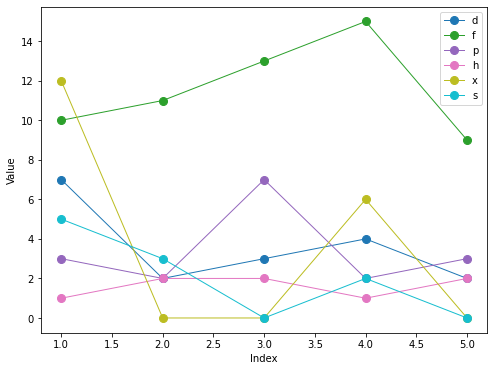

In [263]:
plot_columns(df_uls_1)

### Formulation 2

The variables :
- $z_{i,t}$ the number of items produced in period $i$ to satisfy the demand in period $t$, $\forall t \in \{1,\dots,n\}, \forall i \le t$
- $y_t = 1$ if production occurs in period $t$, otherwise $y_t = 0$, $\forall t \in \{1,\dots,n\}$


The model :

$\begin{cases}
    \text{Minimize} \sum_{t=1}^{n} f_t y_t + \sum_{i=1}^{n}\sum_{t=i}^{n} p_i z_{i,t} + \sum_{t=1}^{n}\sum_{i=1}^{t}\sum_{k=t+1}^{n} h_t z_{i,k}\\
    \sum_{i=1}^t z_{i,t} = d_t & \forall t \in \{1,\dots,n\}\\
    z_{i,t} \le d_t y_i & \forall t \in \{1,\dots,n\} & \forall i \in \{1,\dots,t\}\\
    y_t \in \{0, 1\} & \forall t \in \{1,\dots,n\}\\
    z_{i,t} \ge 0 & \forall t \in \{1,\dots,n\} & \forall i \in \{1,\dots,t\}
\end{cases}$

With : 
- $d_t = \sum_{i=1}^n z_{i,t}$
- $x_i = \sum_{t=i}^n z_{i,t}$
- $s_t = \sum_{k=t+1}^n \sum_{i=1}^t z_{i,k}$


In [415]:
def prepare_data_uls_2(df):
    data = df.to_dict()
    data['n'] = {None:n}
    return data

data_uls_2 = prepare_data_uls_2(df)

In [416]:
data_uls_2

{'d': {1: 7, 2: 2, 3: 3, 4: 4, 5: 2},
 'f': {1: 10, 2: 11, 3: 13, 4: 15, 5: 9},
 'p': {1: 3, 2: 2, 3: 7, 4: 2, 5: 3},
 'h': {1: 1, 2: 2, 3: 2, 4: 1, 5: 2},
 'n': {None: 5}}

In [417]:
def create_uls_2() -> pyo.AbstractModel:
    model = pyo.AbstractModel()

    # immutable parameters
    model.n = pyo.Param(domain = pyo.NonNegativeIntegers)

    # sets
    model.T = pyo.Set(dimen = 1, initialize = T_set_expression)
    model.IT = pyo.Set(dimen = 2, initialize = IT_set_expression)
    model.KIT = pyo.Set(dimen = 3, initialize = KIT_set_expression)
    
    # mutable parameters
    model.d = pyo.Param(model.T, domain = pyo.NonNegativeIntegers, mutable = True)
    model.f = pyo.Param(model.T, domain = pyo.NonNegativeIntegers, mutable = True)
    model.p = pyo.Param(model.T, domain = pyo.NonNegativeIntegers, mutable = True)
    model.h = pyo.Param(model.T, domain = pyo.NonNegativeIntegers, mutable = True)
    
    # variables
    model.z = pyo.Var(model.IT, domain = pyo.NonNegativeIntegers)
    model.y = pyo.Var(model.T, domain = pyo.Binary)

    # objective function
    model.objective = pyo.Objective(expr = objective_expression, sense = pyo.minimize)

    # constraints
    model.demand_satisfaction_constraint = pyo.Constraint(model.T, expr = demand_satisfaction_constraint_expression)
    model.y_constraint = pyo.Constraint(model.IT, expr = y_constraint_expression)
    
    return model

def T_set_expression(model: pyo.AbstractModel) -> pyo.Expression:
    return (t for t in range(1, model.n + 1))

def IT_set_expression(model: pyo.AbstractModel) -> pyo.Expression:
    return ((i, t) for t in model.T for i in range(1, t + 1))

def KIT_set_expression(model: pyo.AbstractModel) -> pyo.Expression:
    return ((k, i, t) for (i, t) in model.IT for k in range(t + 1, model.n + 1))

def objective_expression(model: pyo.AbstractModel) -> pyo.Expression:
    return sum(model.f[t] * model.y[t] for t in model.T) + \
           sum(model.p[i] * model.z[i, t] for i, t in model.IT) + \
           sum(model.h[t] * model.z[i, k] for (k, i ,t) in model.KIT)

def demand_satisfaction_constraint_expression(model, t):
    return sum(model.z[i, t] for i in range(1, t+1)) == model.d[t]

def y_constraint_expression(model, i, t):
    return model.z[i,t] <= model.d[t] * model.y[i]

In [418]:
uls_2 = create_uls_2()
uls_2_instance = create_instance(uls_2, data_uls_2)
uls_2_result = solve_instance_locally(uls_2_instance, "cplex")

uls_2_result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: tmphqj8z4xy
  Lower bound: 86.0
  Upper bound: 86.0
  Number of objectives: 1
  Number of constraints: 21
  Number of variables: 21
  Number of nonzeros: 46
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: 0.02
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 8.6000000000e+01
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.05516386032104492
# -------------

In [293]:
data_uls_2['z'] = {(i, t):int(uls_2_instance.z[i, t].value) for t in range(1, n+1) for i in range(1, t+1)}
data_uls_2['y'] = {t:int(uls_2_instance.y[t].value) for t in range(1, n+1)}
data_uls_2['x'] = {i:sum(data_uls_2['z'][i, t] for t in range(i, n+1)) for i in range(1, n+1)}
data_uls_2['s'] = {t:sum(data_uls_2['z'][i, k] for i in range(1, t+1) for k in range(t+1, n+1)) for t in range(1, n+1)}

In [294]:
data_uls_2

{'d': {1: 7, 2: 2, 3: 3, 4: 4, 5: 2},
 'f': {1: 10, 2: 11, 3: 13, 4: 15, 5: 9},
 'p': {1: 3, 2: 2, 3: 7, 4: 2, 5: 3},
 'h': {1: 1, 2: 2, 3: 2, 4: 1, 5: 2},
 'n': {None: 5},
 'z': {(1, 1): 7,
  (1, 2): 2,
  (2, 2): 0,
  (1, 3): 3,
  (2, 3): 0,
  (3, 3): 0,
  (1, 4): 0,
  (2, 4): 0,
  (3, 4): 0,
  (4, 4): 4,
  (1, 5): 0,
  (2, 5): 0,
  (3, 5): 0,
  (4, 5): 2,
  (5, 5): 0},
 'y': {1: 1, 2: 0, 3: 0, 4: 1, 5: 0},
 'x': {1: 12, 2: 0, 3: 0, 4: 6, 5: 0},
 's': {1: 5, 2: 3, 3: 0, 4: 2, 5: 0}}

In [295]:
df_uls_2 = df.copy()
df_uls_2['x'] = data_uls_2['x'].values()
df_uls_2['s'] = data_uls_2['s'].values()

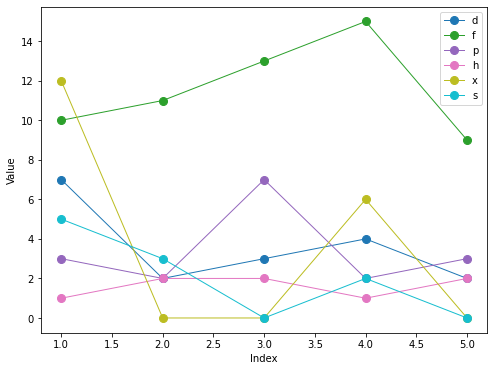

In [297]:
plot_columns(df_uls_2)

## Dynamic Programming

The ULS objective function can be written as :

$\sum_{t=1}^n f_t y_t + \sum_{t=1}^n P_t x_t + H_0 s_0 + K_1$

With :
- $P_t = p_t + \sum_{q=t}^n h_q$
- $H_0 = \sum_{t=1}^n h_t$
- $K_1 = - \sum_{t=1}^n h_t\sum_{q=1}^t d_q$

With this new objective function, we can consider that there is no storage costs (they are hidden), as $s_t$ variables do no longer appear.

There exists an optimal solution to ULS where time slots are partitioned in two classes :
- Regeneration slots: production occurs at these slots and the amount produced covers the demand for the current regeneration slot up to the slot preceding the next regeneration slot.
- Non-regeneration slots: no production occurs at these slots, the stock is used to cover the demand.

Let $G_t$ be ULS optimal objective value when the problem is solved on the time horizon $\{1,\dots,t\}$. The ULS optimal objective value is $G_n$.

If $k\le t$ is the last regeneration time slot, the $G_t$ is equal to :

$G_t = G_{k-1} + f_k + P_k \sum_{q=k}^t d_q$

We can compute $G_t$ for all $t \in \{1,\dots,n\}$ by searching, for each $t$, the last regeneration time slot that incurs the minimum cost, with the following induction formula:

$\begin{cases}
    G_0 = H_0 s_0 + K_1\\
    G_t = \underset{k\in\{1,\dots, t\}}{min}(G_{k-1} + f_k + P_k \sum_{q=k}^t d_q)
\end{cases}$

Finally, $\kappa_t$ stores the last regeneration time slot index useful for building back the solution.

$\kappa_t = \arg G_t$


In [419]:
def prepare_data_dp(df):
    data = df.to_dict()

    data['P'] = {t:data['p'][t] + sum(data['h'][q] for q in range(t, n+1)) for t in range(1, n+1)}
    data['H0'] = sum(data['h'][t] for t in range(1, n+1))
    data['K1'] = - sum(data['h'][t] * data['d'][q] for t in range(1, n+1) for q in range(1, t+1))
    data['s0'] = 0

    data['G'] = {}
    data['kappa'] = {}
    
    return data

data_dp = prepare_data_dp(df)

In [420]:
data_dp

{'d': {1: 7, 2: 2, 3: 3, 4: 4, 5: 2},
 'f': {1: 10, 2: 11, 3: 13, 4: 15, 5: 9},
 'p': {1: 3, 2: 2, 3: 7, 4: 2, 5: 3},
 'h': {1: 1, 2: 2, 3: 2, 4: 1, 5: 2},
 'P': {1: 11, 2: 9, 3: 12, 4: 5, 5: 5},
 'H0': 8,
 'K1': -101,
 's0': 0,
 'G': {},
 'kappa': {}}

In [421]:
# Recursive function that takes n, data, P, G, kappa and returns the objective value for n
def compute_G(n: int, data: dict) -> int:

    # Stopping criteria
    if(n == 0):
        return data['H0'] * data['s0'] + data['K1']
    
    l = []
    
    for k in range(1, n + 1):
        
        # memorization : if a value data['G'][k-1] has already been computed, there's no need to compute it again
        if not ((k - 1) in data['G']):
            data['G'][k - 1] = compute_G(k - 1, data)
        
        l.append(data['G'][k - 1] + data['f'][k] + data['P'][k] * sum(data['d'][q] for q in range(k, n+1)))
    
    min_l = min(l)

    arg_min_l = l.index(min_l)
    
    data['kappa'][n] = arg_min_l + 1
    
    return min_l


In [422]:
data_dp['G'][n] = compute_G(n, data_dp)

In [423]:
data_dp

{'d': {1: 7, 2: 2, 3: 3, 4: 4, 5: 2},
 'f': {1: 10, 2: 11, 3: 13, 4: 15, 5: 9},
 'p': {1: 3, 2: 2, 3: 7, 4: 2, 5: 3},
 'h': {1: 1, 2: 2, 3: 2, 4: 1, 5: 2},
 'P': {1: 11, 2: 9, 3: 12, 4: 5, 5: 5},
 'H0': 8,
 'K1': -101,
 's0': 0,
 'G': {0: -101, 1: -14, 2: 8, 3: 41, 4: 76, 5: 86},
 'kappa': {1: 1, 2: 1, 3: 1, 4: 4, 5: 4}}

In [424]:
data_dp['y'] = {i:int(data_dp['kappa'][i] != data_dp['kappa'][i-1]) if i>1 else data_dp['kappa'][1] for i in range(1, n+1)}

In [425]:
data_dp['x'] = {}
for t in range(1, n+1):
    data_dp['x'][t] = data_dp['d'][t] * data_dp['y'][t]
    for q in range(t+1, n+1):
        if(data_dp['y'][q] == 0):
            data_dp['x'][t] += data_dp['d'][q]
        else:
            break

In [426]:
data_dp

{'d': {1: 7, 2: 2, 3: 3, 4: 4, 5: 2},
 'f': {1: 10, 2: 11, 3: 13, 4: 15, 5: 9},
 'p': {1: 3, 2: 2, 3: 7, 4: 2, 5: 3},
 'h': {1: 1, 2: 2, 3: 2, 4: 1, 5: 2},
 'P': {1: 11, 2: 9, 3: 12, 4: 5, 5: 5},
 'H0': 8,
 'K1': -101,
 's0': 0,
 'G': {0: -101, 1: -14, 2: 8, 3: 41, 4: 76, 5: 86},
 'kappa': {1: 1, 2: 1, 3: 1, 4: 4, 5: 4},
 'y': {1: 1, 2: 0, 3: 0, 4: 1, 5: 0},
 'x': {1: 12, 2: 3, 3: 0, 4: 6, 5: 0}}

In [427]:
data_dp['s'] = {}
data_dp['s'][0] = data_dp['s0']

In [428]:
for t in range(1, n+1):
    data_dp['s'][t] = data_dp['x'][t] - data_dp['d'][t] + data_dp['s'][t-1]

In [429]:
data_dp

{'d': {1: 7, 2: 2, 3: 3, 4: 4, 5: 2},
 'f': {1: 10, 2: 11, 3: 13, 4: 15, 5: 9},
 'p': {1: 3, 2: 2, 3: 7, 4: 2, 5: 3},
 'h': {1: 1, 2: 2, 3: 2, 4: 1, 5: 2},
 'P': {1: 11, 2: 9, 3: 12, 4: 5, 5: 5},
 'H0': 8,
 'K1': -101,
 's0': 0,
 'G': {0: -101, 1: -14, 2: 8, 3: 41, 4: 76, 5: 86},
 'kappa': {1: 1, 2: 1, 3: 1, 4: 4, 5: 4},
 'y': {1: 1, 2: 0, 3: 0, 4: 1, 5: 0},
 'x': {1: 12, 2: 3, 3: 0, 4: 6, 5: 0},
 's': {0: 0, 1: 5, 2: 6, 3: 3, 4: 5, 5: 3}}

In [430]:
print("Objective value :", data_dp['G'][n])

Objective value : 86


In [ ]:

def transform_df_into_dict(df: pd.DataFrame) -> dict:
    """Transform a Pandas dataframe into a dictionary that can be fed into a Pyomo Model"""
    n = df.shape[0]
    data = df.to_dict()
    data['n'] = {None:n}
    return data

In [144]:
def main():
    uls_1 = create_uls_1_abstract_model()
    uls_1_instance = create_instance(uls_1, data)
    result = solve_instance_locally(uls_1_instance, "cplex")
    # email = "brahim.mebrek.pro@gmail.com"
    # result = solve_instance_externally(uls_1_instance, email = email, solver_name = 'cplex')
    print(result)

if __name__ == "__main__":
    main()


Problem: 
- Name: tmpbxj_01yd
  Lower bound: 2527.0
  Upper bound: 2527.0
  Number of objectives: 1
  Number of constraints: 202
  Number of variables: 302
  Number of nonzeros: 502
  Sense: minimize
Solver: 
- Status: ok
  User time: 0.06
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 2.5270000000e+03
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.16553759574890137
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [229]:
for t, v in data['f'].items():
    data['f'][t] += 30

In [231]:
uls_1_2 = create_uls_1_abstract_model()
uls_1_2_instance = create_instance(uls_1_2, data)
result = solve_instance_locally(uls_1_2_instance, "cplex")

In [233]:
df['x_2'] = [int(uls_1_2_instance.x[t].value) for t in range(1, n+1)]
df['s_2'] = [int(uls_1_2_instance.s[t].value) for t in range(1, n+1)]
df['y_2'] = [int(uls_1_2_instance.y[t].value) for t in range(1, n+1)]

In [234]:
df

,d,f,p,h,x,s,y,x_2,s_2,y_2
1,7,10,3,1,12,5,1,18,11,1
2,2,11,2,2,0,3,0,0,9,0
3,3,13,7,2,0,0,0,0,6,0
4,4,15,2,1,6,2,1,0,2,0
5,2,9,3,2,0,0,0,0,0,0


In [ ]:
def plot_lines(df, mode = 'lines+markers'):
    fig = go.Figure()
    for col in df.columns:
        fig.add_trace(go.Scatter(x=df.index, y=df[col].values, name=col,  mode=mode))

    fig.update_layout(width = 950, height = 400)
    fig.show();

In [ ]:

# def read_data(file_name: str, keys: list) -> dict:
#     n = None
#     data = {}
#     with open(file_name) as file:
#         for index, line in enumerate(file):
#             line_content = list(map(int, line.split()))
#             if n is None:
#                 n = len(line_content)
#                 data['n'] = {None:n}
#             data[keys[index]] = dict(zip(range(1, n+1), line_content))
#     return data

# data = read_data(FILE_PATH + FILE_NAME, KEYS)